# Camera Estimation (35 points)

## 3.1 Problem statement

### Q3.1

In [1]:
def DLT(object_3d_coords, image_2d_coords):
    
    N = object_3d_coords.shape[0]
    
    
    # Make sure vars meet the following conditions
    
    assert N >= 6, "DLT requires @least 6 points"
    assert image_2d_coords.shape[0] == N
    assert object_3d_coords.shape[1] == 3
    
    
    T_object_3d_coords, object_3d_coords_n = normalize(object_3d_coords, 3)
    T_image_2d_coords, image_2d_coords_n = normalize(image_2d_coords, 2)
    
    
    A = []
    for i in range(N):
        x, y, z = object_3d_coords_n[i, 0], object_3d_coords_n[i, 1], object_3d_coords_n[i, 2]
        u, v = image_2d_coords_n[i, 0], image_2d_coords_n[i, 1]
        A.append([x, y, z, 1, 0, 0, 0, 0, -u * x, -u * y, -u * z, -u])
        A.append([0, 0, 0, 0, x, y, z, 1, -v * x, -v * y, -v * z, -v])
    
    
    A = np.asarray(A)
    U, S, V = np.linalg.svd(A)
    L = V[-1, :] / V[-1, -1]
    H = L.reshape(3, 4)
    
    
    # Unnormalize
    
    H = np.dot(np.dot(np.linalg.pinv(T_image_2d_coords), H), T_object_3d_coords)
    H = H / H[-1, -1]
    return H


def estimateCamera(image_2d_coords, object_3d_coords):
    
    P = DLT(object_3d_coords, image_2d_coords)
    
    return P[:, 0 : 3], P[:, 3]

### Q3.2

Rotation cannot be the first 3x3 part of M since M is the product of intrinsic and extrinsic parameters.

### Q3.3

If the intinsic parameters is the identity matrix, the first 3x3 part of M will be the rotation matrix because the following equation:

$$
M = K[R | t]
$$

Would decompose into:

$$
M = [R | t]
$$

### Q3.4

Use RQ decomposition to convert first 3x3 part of M into the rotation matrix.

### Q3.5

In [2]:
from scipy.linalg import rq


def estimateCamera2(image_2d_coords, object_3d_coords):
    
    # Estimate camera matrix w/o projective row and estimate C
    
    P = DLT(object_3d_coords, image_2d_coords)
    U, S, V = np.linalg.svd(P)
    C = V[-1 , 0 : 3] / V[-1, -1]
    
    
    # Estimate K and R via RQ
    
    K, R = rq(P[0 : 3, 0 : 3])
    D = np.diag(np.sign(np.diag(K)))
    K = K @ D
    R = D @ R
    t = -R @ C
    return R, t

## 3.2 Visualization

### Q3.6

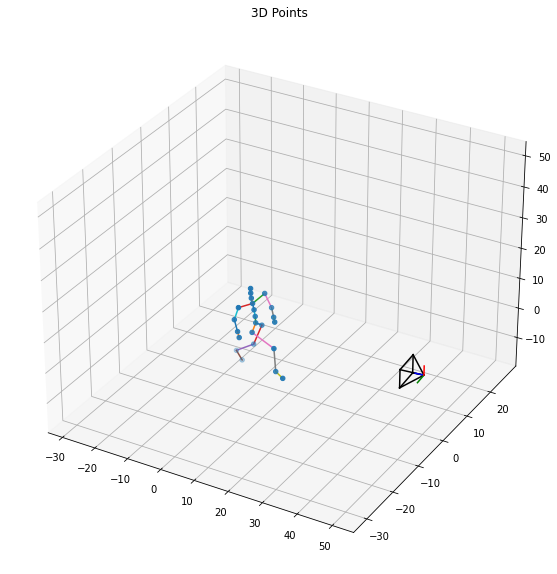

In [3]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import scipy.io as io
import mpl_toolkits.mplot3d.art3d as art3d
import numpy as np


def normalize(x: np.array, nd: int = 2):
    
    # Perform some analysis on x
    
    mean = np.mean(x, 0)
    std = np.std(x)

    
    # Populate W with obtained stats on x

    if nd == 2:
    
        W = np.zeros((3, 3))
        W[0][0] = std
        W[0][1] = 0
        W[0][2] = mean[0]
        W[1][0] = 0
        W[1][1] = std
        W[1][2] = mean[1]
        W[2][0] = 0
        W[2][1] = 0
        W[2][2] = 1
    
    else:
        
        W = np.zeros((4, 4))
        W[0][0] = std
        W[0][1] = 0
        W[0][2] = 0
        W[0][3] = mean[0]
        W[1][0] = 0
        W[1][1] = std
        W[1][2] = 0
        W[1][3] = mean[1]
        W[2][0] = 0
        W[2][1] = 0
        W[2][2] = std
        W[2][3] = mean[2]
        W[3][0] = 0
        W[3][1] = 0
        W[3][2] = 0
        W[3][3] = 1

    # Invert W, perform calculation and return W + normalized x 
    
    W_inv = np.linalg.inv(W)
    x_ext = np.concatenate([x.T, np.ones((1, x.shape[0]))])
    normalized_x = np.dot(W_inv, x_ext)
    normalized_x = normalized_x[0:nd, :].T
    
    return W_inv, normalized_x


def visualize3Dpoints(XYZ, fig, ax):

    adj = io.loadmat("connectMat.mat")["connectMat"]
    pointX = [v[2] for v in XYZ]
    pointY = [v[0] for v in XYZ]
    pointZ = [v[1] for v in XYZ]
    plt.title("3D Points")
    ax.scatter(pointX, pointY, pointZ)

    for i in range(adj.shape[0]):
        for j in range(adj.shape[1]):
            if adj[i][j] == 1:
                X = [pointX[i], pointX[j]]
                Y = [pointY[i], pointY[j]]
                Z = [pointZ[i], pointZ[j]]
                ax.plot(X, Y, Z)


def drawCam(R, t, fig, ax):

    scale = 6.0
    P = scale * np.array([[0.0, 0.0, 0.0],
                        [0.5, 0.5, 0.8],
                        [0.5, -0.5, 0.8],
                        [-0.5, 0.5, 0.8],
                        [-0.5, -0.5, 0.8]])
    t = t.reshape(-1, 1)
    P1_ = R.T @ (P.T - np.tile(t, (1, 5)))
    P1_ = P1_.T
    
    
    def P1(i, j):
        return P1_[i - 1, j - 1]


    def line(X, Y, Z, color = 'blue', **kwargs):
        ax.plot(Y, X, Z, color = color)


    line([P1(1,1), P1(2,1)], [P1(1,3), P1(2,3)], [P1(1,2), P1(2,2)], color = 'black')
    line([P1(1,1), P1(3,1)], [P1(1,3), P1(3,3)], [P1(1,2), P1(3,2)], color = 'black')
    line([P1(1,1), P1(4,1)], [P1(1,3), P1(4,3)], [P1(1,2), P1(4,2)], color = 'black')
    line([P1(1,1), P1(5,1)], [P1(1,3), P1(5,3)], [P1(1,2), P1(5,2)], color = 'black')
    line([P1(2,1), P1(3,1)], [P1(2,3), P1(3,3)], [P1(2,2), P1(3,2)], color = 'black')
    line([P1(3,1), P1(5,1)], [P1(3,3), P1(5,3)], [P1(3,2), P1(5,2)], color = 'black')
    line([P1(5,1), P1(4,1)], [P1(5,3), P1(4,3)], [P1(5,2), P1(4,2)], color = 'black')
    line([P1(4,1), P1(2,1)], [P1(4,3), P1(2,3)], [P1(4,2), P1(2,2)], color = 'black')
    cameraPlane = [[P1(2,1), P1(2,3), P1(2,2)],
                [P1(4,1), P1(4,3), P1(4,2)],
                [P1(3,1), P1(3,3), P1(3,2)],
                [P1(5,1), P1(5,3), P1(5,2)]]
    faces = [1, 0, 2, 3]
    cX = [cameraPlane[p][0] for p in faces]
    cY = [cameraPlane[p][1] for p in faces]
    cZ = [cameraPlane[p][2] for p in faces]
    verts = [list(zip(cY, cX, cZ))]
    patch = art3d.Poly3DCollection(verts, facecolors='green')
    # ax.add_collection3d(patch, zs='z')


    C1 = np.array([P1(2,1), P1(2,3), P1(2,2)])
    C2 = np.array([P1(3,1), P1(3,3), P1(3,2)])
    C3 = np.array([P1(4,1), P1(4,3), P1(4,2)])
    C4 = np.array([P1(5,1), P1(5,3), P1(5,2)])


    O = np.array([P1(1,1), P1(1,3), P1(1,2)])
    Cmid = 0.25 * (C1 + C2 + C3 + C4);


    Lz = np.stack([O, O + 0.5 * (Cmid - O)])
    Lx = np.stack([O, O + 0.5 * (C1 - C3)])
    Ly = np.stack([O, O + 0.5 * (C1 - C2)])
    line(Lz[:, 0], Lz[:, 1], Lz[:, 2], color = 'blue', linewidth = 2)
    line(Lx[:, 0], Lx[:, 1], Lx[:, 2], color = 'green', linewidth = 2)
    line(Ly[:, 0], Ly[:, 1], Ly[:, 2], color = 'red', linewidth = 2)


xyz = io.loadmat("hw1_problem3.mat")["XYZ"]
uv = io.loadmat("hw1_problem3.mat")["xy"][:,:2]
R, t = estimateCamera2(uv, xyz)
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')


# Create cubic bounding box to simulate equal aspect ratio

max_range = np.array([xyz[:,0].max()-xyz[:,0].min(), xyz[:,1].max()-xyz[:,1].min(), t[2]-xyz[:,2].min()]).max()
Xb = 0.5*max_range*np.mgrid[-1:2:2,-1:2:2,-1:2:2][0].flatten() + 0.5*(xyz[:,0].max()+xyz[:,0].min())
Yb = 0.5*max_range*np.mgrid[-1:2:2,-1:2:2,-1:2:2][1].flatten() + 0.5*(xyz[:,1].max()+xyz[:,1].min())
Zb = 0.5*max_range*np.mgrid[-1:2:2,-1:2:2,-1:2:2][2].flatten() + 0.5*(t[2]+xyz[:,2].min())
for xb, yb, zb in zip(Xb, Yb, Zb):
    ax.plot([xb], [yb], [zb], 'w')

visualize3Dpoints(xyz, fig, ax)
drawCam(R, t, fig, ax)
plt.show()